In [ ]:
import os
import cv2
import time
import urllib
import mediapipe as mp
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from PIL import Image
from IPython.display import Image as IPyImage
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from collections import Counter
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
workpath = 'C:/Users/Legion/TFM/Tareas'
os.chdir(workpath)
import warnings
warnings.filterwarnings("ignore")

# LSTM Model

In [2]:
# Crear secuencias
def create_sequences(df, sequence_length):
    sequences = []
    labels = []
    variables = list(df.columns)
    variables.remove('label')
    for i in range(len(df) - sequence_length + 1):
        seq = df.iloc[i:i + sequence_length][variables].values
        label = df.iloc[i + sequence_length - 1]['label']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels), len(variables)


In [ ]:
# Usar archivos de Dataset
vid_list = os.listdir(workpath+'/VideosTR/Data2model')
abs_paths_csv = [workpath+'/VideosTR/Data2model/'+x for x in vid_list if '.csv' in x]
abs_paths_csv

In [4]:
# Crear secuencias para cada uno de los videos (100 frames por secuencia)
secuencias = []
labels = []
sequence_length = 100
label_dict = {'Dominada': 0, 'Fondo': 1,
              'Flexione': 2, 'Sentadilla': 3,
              'Standup': 4}
for path in abs_paths_csv:
    df = pd.read_csv(path, sep=';', index_col=0)
    seq, lbl, ncols = create_sequences(df, sequence_length)
    secuencias.append(seq)
    labels.append(lbl)

X = np.concatenate(secuencias)
Y = np.concatenate(labels)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7294, stratify=Y)

In [9]:

model = keras.Sequential()

# If you crete a second layer you must set return_sequences=True
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(sequence_length, ncols))
)
# Second Bidirectional layer
model.add(layers.Bidirectional(layers.LSTM(32)))
# Output
model.add(layers.Dense(5, activation= 'softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Usar 'sparse_categorical_crossentropy' para clasificación multiclase

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 100, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,101 (422.27 KB)

 Trainable params: 108,101 (422.27 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.8860 - loss: 0.3196 - val_accuracy: 0.9043 - val_loss: 0.2417
Epoch 2/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.9780 - loss: 0.0694 - val_accuracy: 0.9910 - val_loss: 0.0321
Epoch 3/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.9857 - loss: 0.0455 - val_accuracy: 0.9841 - val_loss: 0.0546
Epoch 4/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.9905 - loss: 0.0285 - val_accuracy: 0.9947 - val_loss: 0.0198
Epoch 5/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9914 - loss: 0.0264 - val_accuracy: 0.9969 - val_loss: 0.0098
Epoch 6/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.9948 - loss: 0.0176 - val_accuracy: 0.9983 - val_loss: 0.0049
Epoch 7/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.9925 - loss: 0.0235 - val_accuracy: 0.9907 - val_loss: 0.0220
Epoch 8/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - accuracy: 0.9947 -

KeyboardInterrupt: 

In [10]:
es_callback = keras.callbacks.EarlyStopping(
    monitor="accuracy", min_delta=0.0001, patience=3)

history = model.fit(
    X_train, y_train,
    epochs=25,
    validation_split=0.2,
    callbacks=[es_callback]
)

Epoch 1/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 114s 75ms/step - accuracy: 0.8354 - loss: 0.4705 - val_accuracy: 0.9783 - val_loss: 0.0622
Epoch 2/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 105s 72ms/step - accuracy: 0.9849 - loss: 0.0506 - val_accuracy: 0.9952 - val_loss: 0.0205
Epoch 3/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 105s 72ms/step - accuracy: 0.9914 - loss: 0.0327 - val_accuracy: 0.9966 - val_loss: 0.0210
Epoch 4/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 104s 72ms/step - accuracy: 0.9864 - loss: 0.0430 - val_accuracy: 0.9987 - val_loss: 0.0053
Epoch 5/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 106s 73ms/step - accuracy: 0.9968 - loss: 0.0107 - val_accuracy: 0.9867 - val_loss: 0.0424
Epoch 6/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 104s 71ms/step - accuracy: 0.9903 - loss: 0.0327 - val_accuracy: 0.9993 - val_loss: 0.0038
Epoch 7/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 101s 70ms/step - accuracy: 0.9884 - loss: 0.0379 - val_accuracy: 0.9992 - val_loss: 0.0028
Epoch 8/25
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 102s 70ms/step - accuracy: 

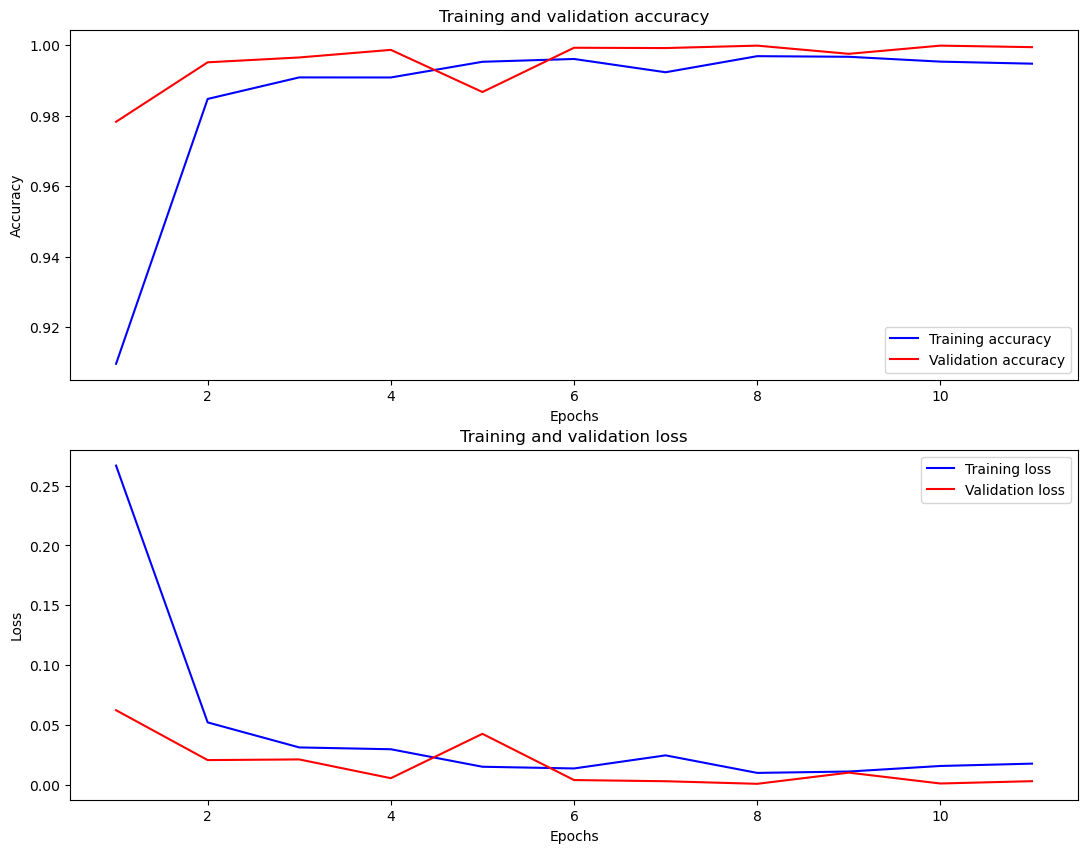

In [20]:
# Visualizar la evolución del modelo
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Número de epochs
epochs = range(1, len(accuracy) + 1)

# Crear la gráfica para accuracy
plt.figure(figsize=(13,10))

plt.subplot(2, 1, 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Crear la gráfica para loss
plt.subplot(2, 1, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

In [19]:
# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

454/454 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 1.0000 - loss: 3.6493e-04
Test Accuracy: 100.00%


Guardamos el modelo

In [ ]:
model.save('C:/Users/Legion/TFM/Tareas/Models/classification_model_seq100.h5')

In [21]:
keras.saving.save_model(model, 'C:/Users/Legion/TFM/Tareas/Models/classification_model_seq100.keras')

In [22]:
import pickle
with open('C:/Users/Legion/TFM/Tareas/Models/classification_model_seq100.pickle', 'wb') as archivo:
    pickle.dump(model, archivo)

Prueba del modelo

In [ ]:
dfprueba = pd.read_csv('C:/Users/Legion/TFM/Tareas/VideosTR/PruebasDeModelo/SentadillaPr.csv', sep=';', index_col=0)
dfprueba['label'] = [3 for c in range(len(dfprueba))]
seqprueba, lblprueba, ncols = create_sequences(df, sequence_length)


In [56]:
dfprueba

,NOSE_x,NOSE_y,NOSE_z,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,LEFT_ELBOW_x,...,RIGHT_KNEE_x,RIGHT_KNEE_y,RIGHT_KNEE_z,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_z,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_z,label
0,0.254463,1.0,0.475044,0.261630,0.856578,0.950855,0.038177,0.933296,0.393201,0.564076,...,0.085935,0.313296,0.212139,0.160806,0.055263,0.858689,0.000000,0.0,0.135494,Sentadilla_Prueb
1,0.270753,1.0,0.497388,0.281052,0.855999,0.947985,0.044158,0.930866,0.418478,0.574596,...,0.090455,0.313073,0.392489,0.211237,0.058708,1.000000,0.000000,0.0,0.348671,Sentadilla_Prueb
2,0.279818,1.0,0.518807,0.288824,0.854549,0.945792,0.048975,0.928853,0.440783,0.580790,...,0.093826,0.311598,0.418993,0.228623,0.058844,1.000000,0.000000,0.0,0.377385,Sentadilla_Prueb
3,0.279654,1.0,0.525229,0.290991,0.853932,0.965555,0.052241,0.927329,0.445820,0.583425,...,0.097231,0.309308,0.427577,0.231596,0.055284,1.000000,0.000000,0.0,0.419518,Sentadilla_Prueb
4,0.279721,1.0,0.523170,0.292232,0.853586,0.967498,0.051761,0.925912,0.458297,0.584628,...,0.098536,0.305827,0.453302,0.232834,0.051954,1.000000,0.000000,0.0,0.448897,Sentadilla_Prueb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0.298004,1.0,0.391467,0.384229,0.838290,0.771978,0.073747,0.897929,0.434783,0.565805,...,0.092773,0.295137,0.321774,0.264046,0.054644,1.000000,0.000000,0.0,0.248506,Sentadilla_Prueb
294,0.330232,1.0,0.299238,0.427138,0.836448,0.693693,0.072671,0.895994,0.333329,0.592548,...,0.109843,0.289839,0.255705,0.298615,0.054403,1.000000,0.000000,0.0,0.194975,Sentadilla_Prueb
295,0.390350,1.0,0.279040,0.498063,0.834855,0.684721,0.100949,0.895182,0.327767,0.658794,...,0.139794,0.276052,0.287207,0.354479,0.054450,1.000000,0.018209,0.0,0.245034,Sentadilla_Prueb
296,0.507475,1.0,0.142846,0.626590,0.830313,0.532476,0.163397,0.892084,0.236192,0.756438,...,0.226902,0.267338,0.343882,0.467463,0.055730,1.000000,0.100583,0.0,0.353528,Sentadilla_Prueb


In [58]:
y_pred = model.predict(seqprueba)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


In [ ]:
from collections import Counter

preds = [np.argmax(x) for x in y_pred]
count_preds = Counter(preds)
final_pred_num = count_preds.most_common(1)[0]
num_to_excercise = {0: 'Dominada', 1: 'Fondo',
                    2: 'Flexión', 3: 'Sentadilla'}
predicted_excercise = num_to_excercise[final_pred_num[0]]

# k-NN Model

In [2]:
# leer todos los training datasets
vid_list = os.listdir(workpath+'/VideosTR/Data2model')
abs_paths_csv = [workpath+'/VideosTR/Data2model/'+x for x in vid_list if '.csv' in x]
list_dfs = []
for csv in abs_paths_csv:
    list_dfs.append(pd.read_csv(csv, sep=';', index_col=0))

data = pd.concat(list_dfs)
del list_dfs

Y = data[['label']]
X = data.drop(columns='label')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7294, stratify=Y)


In [ ]:
def knn_try(X_train, X_test, y_train, y_test, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    print(f'Modelo con k = {k}')
    # Entrenar el modelo
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    # Calcular la precisión del modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Precisión del modelo: {accuracy * 100:.2f}%')
    return knn

for k in range(3, 8):
    knn_try(X_train, X_test, y_train, y_test, k)
    

Modelo con k = 3


C:\Users\Bruno\TFM\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Precisión del modelo: 93.25%
Modelo con k = 4


C:\Users\Bruno\TFM\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Precisión del modelo: 92.93%
Modelo con k = 5


C:\Users\Bruno\TFM\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [7]:
modelo_k3 = knn_try(X_train, X_test, y_train, y_test, 3)

Modelo con k = 3


C:\Users\Bruno\TFM\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Precisión del modelo: 95.56%


In [8]:
import pickle
with open('C:/Users/Bruno/TFM/Tareas/Models/classification_model_knn3.pickle', 'wb') as archivo:
    pickle.dump(modelo_k3, archivo)